In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA

# 평가 함수로 사용할 RMSLE를 계산하는 함수 정의의
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

In [2]:
# 전처리(Label Encoding)한 데이터 로드: One-Hot Encoded & StandardScaled
X_train = pd.read_csv('TestData/train_data_oh_scaled.csv')
y_train = pd.read_csv('TestData/train_target.csv').iloc[:, 0]
X_val = pd.read_csv('TestData/val_data_oh_scaled.csv')
y_val = pd.read_csv('TestData/val_target.csv').iloc[:, 0]
X_test = pd.read_csv('TestData/test_data_oh_scaled.csv')


# 학습에 사용하지 않을 컬럼 삭제
X_train.drop(['id', 'date', 'date_type', 'day'], axis=1, inplace=True)
X_val.drop(['id', 'date', 'date_type', 'day'], axis=1, inplace=True)
X_test.drop(['id', 'date', 'date_type', 'day'], axis=1, inplace=True)

In [ ]:
# PCA 모델 학습
pca = PCA(n_components=X_train.shape[1])  # 모든 성분 유지
pca.fit(X_train)

# 성분별 설명 분산 비율
explained_variance = pca.explained_variance_ratio_

# 성분별 설명 분산 비율을 데이터프레임으로 변환
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance
})

# 설명 분산 비율을 높은 순으로 정렬
explained_variance_df = explained_variance_df.sort_values(by='Explained Variance Ratio', ascending=False).reset_index(drop=True)

# 누적 설명 분산 비율 계산
explained_variance_df['Cumulative Variance Ratio'] = explained_variance_df['Explained Variance Ratio'].cumsum()

# 모든 행과 열을 출력하도록 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 결과 출력
explained_variance_df.to_csv('explained_variance_df.csv')

print(explained_variance_df)


import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
plt.plot(explained_variance_df['Principal Component'], explained_variance_df['Cumulative Variance Ratio'])
plt.show()

# explained_variance 누적이 80% 되는 컴포넌트 개수는 42개 (80% 설명력: PC42,0.005358110779507352,누적: 0.80317231403952)

In [4]:
# 상위 42 개의 중요한 성분을 선택하는 경우 (80% 설명력: PC42,0.005358110779507352,0.80317231403952)
n_important = 42

# PCA 변환 적용
X_train_pca_transformed = pca.transform(X_train)
X_val_pca_transformed = pca.transform(X_val)
X_test_pca_transformed = pca.transform(X_test)

# PCA 변환 결과를 DataFrame으로 변환
train_pca_df = pd.DataFrame(X_train_pca_transformed, columns=[f'PC{i+1}' for i in range(X_train.shape[1])])
val_pca_df = pd.DataFrame(X_val_pca_transformed, columns=[f'PC{i+1}' for i in range(X_val.shape[1])])
test_pca_df = pd.DataFrame(X_test_pca_transformed, columns=[f'PC{i+1}' for i in range(X_test.shape[1])])

# train 데이터에 sales 추가 (타겟 변수)
train_pca_df['sales'] = y_train.values

# PCA 성분들과 sales 간의 상관계수 계산
correlations = train_pca_df.corr()['sales'].drop('sales').abs()

# 상위 몇 개의 성분을 기준으로 중요한 성분 선택
important_components = correlations.sort_values(ascending=False)

# 상위 중요한 성분 선택
selected_components = important_components.index[:n_important]

# Train, Validation, Test 데이터를 축소된 성분으로 변환
X_train_pca = train_pca_df[selected_components]
X_val_pca = val_pca_df[selected_components]
X_test_pca = test_pca_df[selected_components]

# 출력 확인 (선택된 중요한 성분과 그 데이터프레임)
print(f"Selected components: {selected_components}")
print("X_train_pca:", X_train_pca.head())
print("X_val_pca:", X_val_pca.head())
print("X_test_pca:", X_test_pca.head())


X_train_pca.to_csv(f'TestData/X_train_pca_{n_important}.csv', index=False)
X_val_pca.to_csv(f'TestData/X_val_pca_{n_important}.csv', index=False)
X_test_pca.to_csv(f'TestData/X_test_pca_{n_important}.csv', index=False)
    

Selected components: Index(['PC90', 'PC2', 'PC89', 'PC1', 'PC229', 'PC3', 'PC65', 'PC61', 'PC73',
       'PC4', 'PC108', 'PC64', 'PC75', 'PC63', 'PC7', 'PC6', 'PC84', 'PC85',
       'PC44', 'PC76', 'PC20', 'PC104', 'PC8', 'PC77', 'PC78', 'PC204', 'PC47',
       'PC10', 'PC59', 'PC19', 'PC91', 'PC72', 'PC51', 'PC58', 'PC70', 'PC25',
       'PC71', 'PC265', 'PC81', 'PC69', 'PC22', 'PC9'],
      dtype='object')
X_train_pca:        PC90       PC2      PC89       PC1         PC229       PC3      PC65  \
0 -0.049330  0.414791 -0.065128  1.035323  1.720846e-15  1.104362  0.058808   
1 -0.051014  0.414663 -0.066330  1.035375  1.831868e-15  1.104375  0.037202   
2 -0.046553  0.415001 -0.063146  1.035236  1.720846e-15  1.104340  0.006350   
3  0.259004  0.438183  0.154925  1.025678 -1.831868e-15  1.101950  0.607249   
4 -0.051033  0.414662 -0.066343  1.035376  1.942890e-15  1.104375  0.157525   

       PC61      PC73       PC4  ...      PC51      PC58      PC70      PC25  \
0  0.060150 -0.00553

    Principal Component  Explained Variance Ratio  Cumulative Variance Ratio
0                   PC1              1.249933e-01                   0.124993
1                   PC2              8.799984e-02                   0.212993
2                   PC3              6.113808e-02                   0.274131
3                   PC4              4.901881e-02                   0.323150
4                   PC5              3.866196e-02                   0.361812
5                   PC6              3.246444e-02                   0.394276
6                   PC7              2.737785e-02                   0.421654
7                   PC8              2.211237e-02                   0.443767
8                   PC9              2.124883e-02                   0.465015
9                  PC10              2.107514e-02                   0.486091
10                 PC11              1.763786e-02                   0.503728
11                 PC12              1.507160e-02                   0.518800

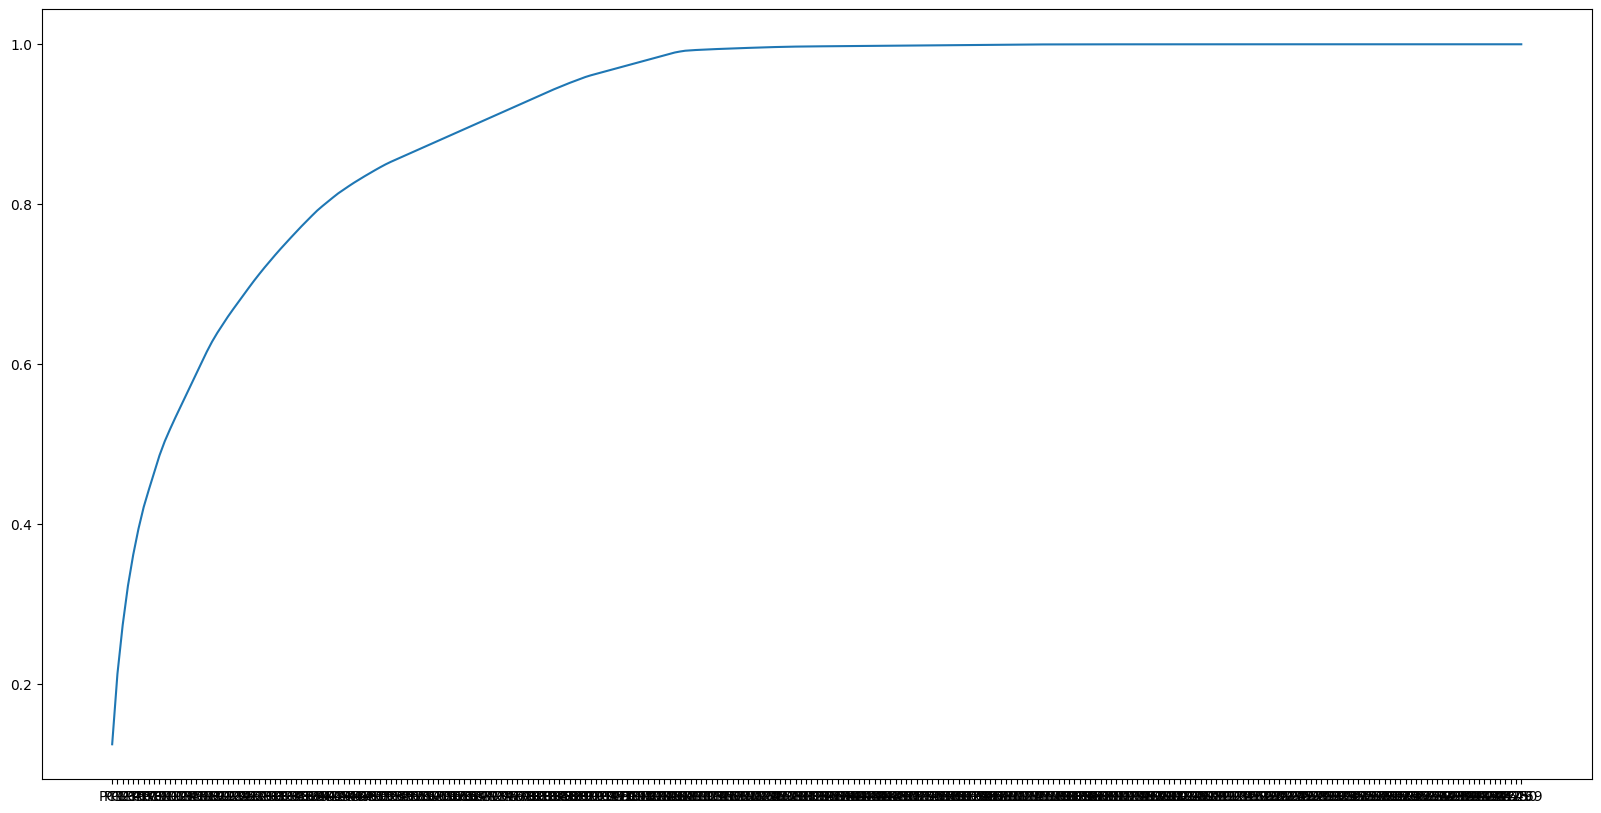

In [29]:
# # 성분별 설명 분산 비율
# explained_variance = pca.explained_variance_ratio_

# # 성분별 설명 분산 비율을 데이터프레임으로 변환
# explained_variance_df = pd.DataFrame({
#     'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
#     'Explained Variance Ratio': explained_variance
# })

# # 설명 분산 비율을 높은 순으로 정렬
# explained_variance_df = explained_variance_df.sort_values(by='Explained Variance Ratio', ascending=False).reset_index(drop=True)

# # 누적 설명 분산 비율 계산
# explained_variance_df['Cumulative Variance Ratio'] = explained_variance_df['Explained Variance Ratio'].cumsum()

# # 모든 행과 열을 출력하도록 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # 결과 출력
# explained_variance_df.to_csv('explained_variance_df.csv')

# print(explained_variance_df)


# import matplotlib.pyplot as plt 
# plt.figure(figsize=(20,10))
# plt.plot(explained_variance_df['Principal Component'], explained_variance_df['Cumulative Variance Ratio'])
# plt.show()